In [1]:
import os
import sys
from pathlib import Path
src_dir = Path(os.getcwd()).parent / 'src'
sys.path.append(str(src_dir))

In [2]:
import sympy
import sympytorch
import linalg as spla
import sympy_compiler as sc
import pdetree as pdet
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from kernels import *
from pde_utils import *

Heat equation with non-linear boundary:
$$
\begin{align}
\Delta u(x) &= 0 & \text{$x \in \mathcal{X}$ }\\
u(x) &= g(x) & \text{$x \in \partial \mathcal{X}$ }
\end{align}
$$
where, $\mathcal{X} = [0,1]\times[0,1], \partial \mathcal{X}$ are the domain and boundary of the defined PDE.

In [3]:
# boundary function for the PDE
def rectangle_boundary_fn(x):
    return 1.0 * (x[:,1] == 1.)

In [4]:
node = pdet.parse("d(d(u,x0),x0) + d(d(u,x1),x1)")
kernel, x_sym, y_sym = rbf_kernel_sympy(n_dims=2, amplitude=1.0, length_scale=0.2)
lxy, lx, ly = sc.pdet_compile(node, kernel, x_sym, y_sym)

In [5]:
lxy_submod = sympytorch.SymPyModule(expressions=[lxy])
lx_submod = sympytorch.SymPyModule(expressions=[lx])
ly_submod = sympytorch.SymPyModule(expressions=[ly])
kernel_submod = sympytorch.SymPyModule(expressions=[kernel])

In [6]:
lxy_mod = SympyKernel(lxy_submod, x_sym, y_sym)
lx_mod = SympyKernel(lx_submod, x_sym, y_sym)
ly_mod = SympyKernel(ly_submod, x_sym, y_sym)
kernel_mod = SympyKernel(kernel_submod, x_sym, y_sym)

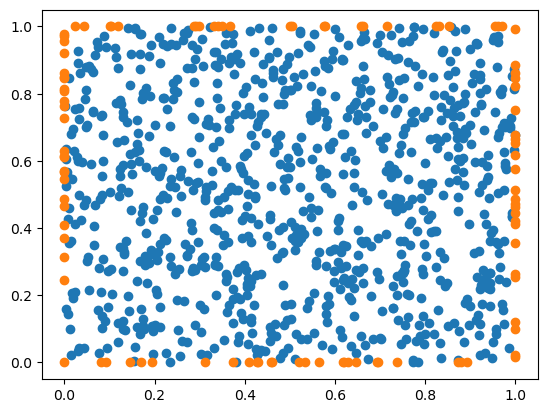

In [7]:
n_domain = 30**2
n_boundary = 25
dim_ranges = torch.tensor([[0., 0.],[1., 1.]])
boundary_spec = [
    (n_boundary, (0., None)),
    (n_boundary, (1., None)),
    (n_boundary, (None, 0.)),
    (n_boundary, (None, 1.)),
]
x_domain, x_boundary = sample_uniform_grid(dim_ranges, n_domain, boundary_spec)
x_train = torch.vstack([x_domain, x_boundary])
plt.scatter(x_domain[:,0], x_domain[:,1])
plt.scatter(x_boundary[:,0], x_boundary[:,1])
plt.show()


In [8]:
y_boundary = rectangle_boundary_fn(x_boundary)
y_domain = torch.zeros(n_domain)
y_train = torch.cat([y_domain, y_boundary])

In [9]:
theta = construct_joint_kernel_from_linear_ops(lxy_mod, lx_mod, kernel_mod, x_domain, x_boundary)

In [10]:
n_points = 100
x_test_tuple = gen_grid_points(dim_ranges, n_points)
x_test_ls = [x_test_ind.flatten() for x_test_ind in x_test_tuple]
x_test = torch.stack(x_test_ls, dim=1)

In [11]:
y_train = y_train.unsqueeze(-1)
print(y_train.shape)

torch.Size([1000, 1])


In [12]:

test_mean = infer_from_kernel(theta, ly_mod, kernel_mod, x_domain, x_boundary, y_train, x_test)

In [13]:
test_mean_grid = test_mean.view(n_points, n_points)
print(test_mean_grid.shape)

torch.Size([100, 100])


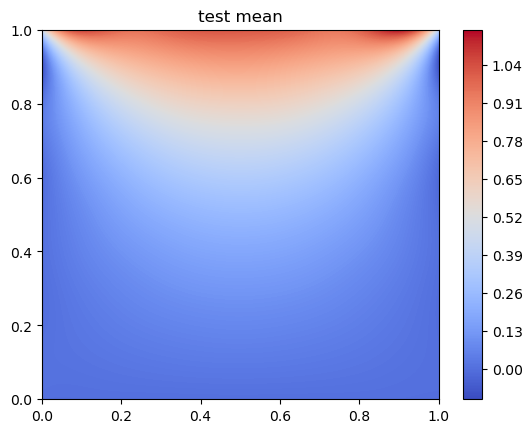

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
surf = ax.contourf(x_test[:,0].view(n_points, n_points).detach().numpy(),
                   x_test[:,1].view(n_points, n_points).detach().numpy(),
                   test_mean_grid.detach().numpy(),
                   levels=255, 
                   cmap=plt.cm.coolwarm)
ax.set_title("test mean")
fig.colorbar(surf)
plt.show()

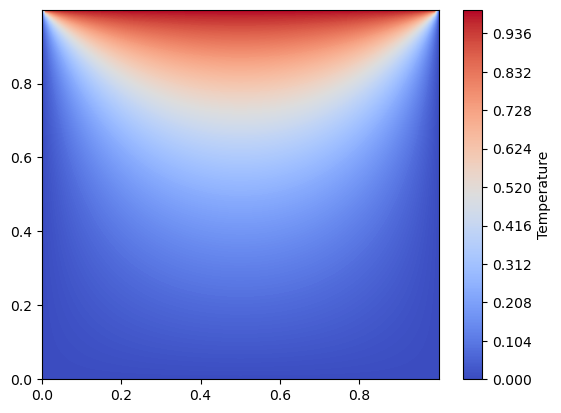

In [15]:
# Numeric solution:
h = 0.0101
length_x = 1.0
length_y = 1.0
x_vals = np.arange(0, length_x + 0.001, h)
y_vals = np.arange(0, length_y + 0.001, h)

# The coefficient matrix A is now m*n by m*n, 
# since that is the total number of points.
# The right-hand side vector b is m*n by 1.
A = np.zeros((len(x_vals)*len(y_vals), len(x_vals)*len(y_vals)))
b = np.zeros(len(x_vals)*len(y_vals))

u_left = 0
u_right = 0
u_bottom = 0
u_top = 1

for j, y in enumerate(y_vals):
    for i, x in enumerate(x_vals):
        # for convenience, calculate all indices now
        kij = j*len(x_vals) + i
        kim1j = j*len(x_vals) + i - 1
        kip1j = j*len(x_vals) + i + 1
        kijm1 = (j-1)*len(x_vals) + i
        kijp1 = (j+1)*len(x_vals) + i
        if i == 0:
            # this is the left boundary
            A[kij, kij] = 1
            b[kij] = u_left
        elif i == len(x_vals) - 1:
            # right boundary
            A[kij, kij] = 1
            b[kij] = u_right
        elif j == 0:
            # bottom boundary
            A[kij, kij] = 1
            b[kij] = u_bottom
        elif j == len(y_vals) - 1:
            # top boundary
            A[kij, kij] = 1
            b[kij] = u_top
        else:
            # coefficients for interior points, based
            # on the recursion formula
            A[kij, kim1j] = 1
            A[kij, kip1j] = 1
            A[kij, kijm1] = 1
            A[kij, kijp1] = 1
            A[kij, kij] = -4
u = np.linalg.solve(A, b)

u_square = np.reshape(u, (len(y_vals), len(x_vals)))
plt.contourf(x_vals, y_vals, u_square, levels=255, cmap=plt.cm.coolwarm)
plt.colorbar(label='Temperature')
plt.show()

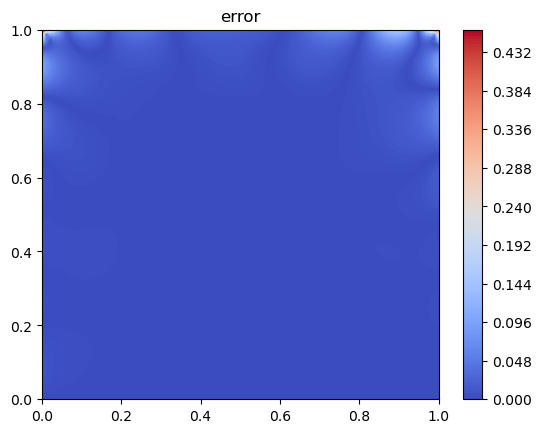

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
surf = ax.contourf(x_test[:,0].view(n_points, n_points).detach().numpy(),
                   x_test[:,1].view(n_points, n_points).detach().numpy(),
                   np.abs(test_mean_grid.detach().numpy() - u_square),
                   levels=255, 
                   cmap=plt.cm.coolwarm)
ax.set_title("error")
fig.colorbar(surf)
plt.show()